In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as functional
from torch.autograd import Variable
import matplotlib.pyplot as plt
import importlib

# Modify here

In [2]:
config_path = 'model.v0_5'
x_train_filename = '../data/input_formated/v0_5/x_train.csv'
y_train_filename = '../data/input_formated/v0_5/y_train.csv'
model_save = 'model/v0_5/checkpoint'

learning_rate = 0.3
num_epochs = 1000
check_point = 100

# Read data and config file

In [3]:
model_config, loss_lib = None, None

In [4]:
loss_lib = importlib.import_module('%s.loss_func' %config_path)

In [5]:
model_config = importlib.import_module('%s.model_config'% config_path)


In [6]:
x_train = pd.read_csv(x_train_filename).iloc[:, 1:]
y_train = pd.read_csv(y_train_filename).iloc[:, 1:]
x_train = np.array(x_train, dtype = np.float32)
y_train = np.array(y_train, dtype = np.float32)

In [7]:
def train(x_data, y_data, learning_rate, num_epochs, check_point = 100):
    n = int(0.8 * len(x_data))
    x_train, y_train = x_data[:n,:], y_data[:n, :]
    x_val, y_val = x_data[n:, :], y_data[n:, :]
    
    model, optimizer = model_config.init(x_train.shape[1], y_train.shape[1], learning_rate)
    train_loss_list, val_loss_list = [], []

    #early stopping
    patience = model_config.max_patience
    best_val = None
    
    # Train the Model 
    for epoch in range(num_epochs):
        # Convert numpy array to torch Variable
        inputs = Variable(torch.from_numpy(x_train))
        targets = Variable(torch.from_numpy(y_train), requires_grad = False)

        # Forward + Backward + Optimize
        optimizer.zero_grad()  
        outputs = model(inputs)
        
        train_loss = loss_lib.loss_fnc(outputs, targets).sum()
        train_loss_list.append(train_loss.data[0])
        
        #validate
        inputs = Variable(torch.from_numpy(x_val))
        targets = Variable(torch.from_numpy(y_val))
        outputs = model(inputs)   
        val_loss = loss_lib.loss_fnc(outputs, targets).sum().data[0]
        val_loss_list.append(val_loss)
        
        #optimize
        train_loss.backward()
        optimizer.step()
        
        if (epoch == 0) or ((epoch+1) % check_point == 0) or (epoch == num_epochs-1):
            print ('Epoch [%d/%d], Training Loss: %.4f, Validating Loss: %.4f' 
                   %(epoch+1, num_epochs, train_loss.data[0], val_loss))
            torch.save(model, '%s_%s.pth' % (model_save, epoch+1))

        if (best_val is None) or ((best_val is not None) and (val_loss < best_val)) :
            best_val = val_loss
            patience = model_config.max_patience
        else:
            patience -= 1
        if patience == 0:
            print 'Early stopping at %d' % epoch
            break
        

    # Plot the graph
    print 'Plot graph from epoch 10th'
    plt.plot(range(len(train_loss_list))[10:], train_loss_list[10:], label='train')
    plt.plot(range(len(train_loss_list))[10:], val_loss_list[10:], label = 'validate')
    plt.legend()
    plt.show()
    return model

Epoch [1/1000], Training Loss: 7.0282, Validating Loss: 6.9011
Epoch [100/1000], Training Loss: 0.2506, Validating Loss: 0.2557
Epoch [200/1000], Training Loss: 0.2461, Validating Loss: 0.2503
Epoch [300/1000], Training Loss: 0.2455, Validating Loss: 0.2497
Epoch [400/1000], Training Loss: 0.2454, Validating Loss: 0.2496
Epoch [500/1000], Training Loss: 0.2454, Validating Loss: 0.2495
Epoch [600/1000], Training Loss: 0.2454, Validating Loss: 0.2495
Epoch [700/1000], Training Loss: 0.2454, Validating Loss: 0.2495
Epoch [800/1000], Training Loss: 0.2454, Validating Loss: 0.2495
Epoch [900/1000], Training Loss: 0.2454, Validating Loss: 0.2495
Epoch [1000/1000], Training Loss: 0.2454, Validating Loss: 0.2495
Plot graph from epoch 10th


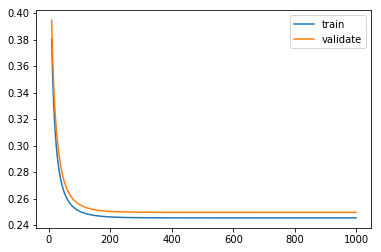

In [8]:
model = train(x_train, y_train, learning_rate = learning_rate, num_epochs =num_epochs, check_point=check_point)